In [1]:
from nltk import word_tokenize
from nltk.corpus import stopwords
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

### Load Dataset

In [2]:
df = pd.read_csv('cleaned_tweets.csv')
print('number of sentences: {}'.format(len(df)))
# extract all sentences to list
sentences = df.string.values.tolist()
df.head(5)

number of sentences: 1864


,Is Pos?,Is Neg?,Is Neutral?,Is Ad/Spam?,Is Review?,Is News?,string
0,0.0,1.0,0.0,0.0,0.0,0.0,screams in different languages
1,0.0,1.0,0.0,0.0,0.0,1.0,families to sue over legionnaires more than fa...
2,0.0,1.0,0.0,1.0,0.0,1.0,pandemonium in aba as woman delivers baby with...
3,0.0,1.0,0.0,0.0,0.0,0.0,my emotions are train wreck my body is train w...
4,0.0,1.0,0.0,0.0,0.0,1.0,alton brown just did livestream and he burned ...


**pick a label type**

In [3]:
print(df.columns.values.tolist()[:-1])
col_label = 'Is News?'

['Is Pos?', 'Is Neg?', 'Is Neutral?', 'Is Ad/Spam?', 'Is Review?', 'Is News?']


#### obtain training dataset (x, y) with dataframe format

In [4]:
stop = 1189
df_y = df[df[col_label].notnull()][col_label].iloc[0:stop]
df_x = df[df[col_label].notnull()]['string'].iloc[0:stop]
print(len(df_y), len(df_x))

1189 1189


### Preprocessing

1. remove stopwords in each sentences
2. find each word frequency

In [5]:
#---------- 1 ----------
word_index = {}
for i, sent in enumerate(sentences):
    tokens = [w for w in word_tokenize(sent) if w not in stopwords.words('english')]
    sentences[i] = ' '.join(tokens)
    sentences[i] = str(sentences[i])
    for t in tokens:
        if t not in word_index:
            word_index[t] = 1
        else:
            word_index[t] += 1
#---------- 2 ----------
df_word = pd.DataFrame(columns = ['word', 'freq'])
w = []
f = []
for k, v in word_index.items():
    w.append(k)
    f.append(v)
df_word['word'] = w
df_word['freq'] = f
df_word = df_word.sort_values(by = 'freq', ascending = False, ignore_index = True)
df_word

,word,freq
0,like,97
1,amp,72
2,get,56
3,new,53
4,fire,52
...,...,...
6582,richard,1
6583,kaiser,1
6584,member,1
6585,mississippi,1


**tokenize words:**<br>
**pick number of words you want to tokenize**

In [6]:
num_words = 3100
words = df_word.word.values[0:num_words].tolist()
tokenizer = Tokenizer(num_words = num_words, oov_token = "<OOV>")
tokenizer.fit_on_texts(words)
len(tokenizer.word_index)

3101

#### get X TRAIN

In [7]:
sequences = tokenizer.texts_to_sequences(sentences[0:stop])

In [8]:
sequences[0:10]

[[176, 649, 1330],
 [75, 792, 144, 75, 500, 200, 619, 144, 796],
 [489, 1341, 598, 2419, 353, 103, 142, 493],
 [1028, 59, 101, 23, 59, 101, 101],
 [1, 352, 1, 192, 950, 1, 70, 2408, 1248, 190, 1, 1244],
 [97, 356, 1230, 248, 1232, 1236],
 [1, 142, 1, 2394, 222, 252, 2392],
 [501, 1290, 77, 134, 1296, 68, 1, 21, 178, 2351, 35, 1],
 [85, 303, 2326, 238, 11, 1276, 53, 490, 503, 258, 840],
 [2378, 55, 2380, 946, 1440, 46, 181, 115, 899, 517, 1, 1]]

In [9]:
i = 10
print(sequences[i])
print(sentences[i])

[1, 1425, 205, 1, 115, 1, 13, 1, 91, 1, 513]
idm burn whole gotham city bcs going laugh everyone theyre panicking


**statistic of lengths in each sentence**

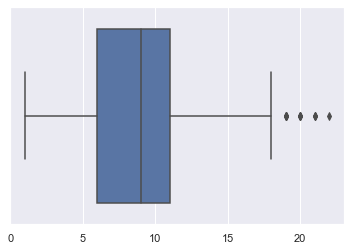

In [10]:
lens = []
for s in sequences:
    lens.append(len(s))
plt.figure(); sns.boxplot(lens)

In [11]:
max_len = 12
input_sequences = pad_sequences(sequences, padding = 'pre', truncating = 'post', maxlen = max_len)
print(input_sequences.shape)

(1189, 12)


#### get X, and Y

In [12]:
y = df_y.values
x_input = input_sequences
x_input.shape, y.shape

((1189, 12), (1189,))

In [13]:
print('positive case: ', len(y[y == 1]))
print('negative case: ', len(y[y == 0]))

positive case:  340
negative case:  849


### Input Pipeline

In [14]:
import tensorflow as tf
from sklearn.model_selection import train_test_split

**split train and test**

In [15]:
rs = 41
pos_trn, pos_val, _, _ = train_test_split(x_input[y == 1], y[y == 1], test_size = 0.2, random_state = rs)
neg_trn, neg_val, _, _ = train_test_split(x_input[y == 0], y[y == 0], test_size = 0.25, random_state = rs)
pos_trn = np.vstack((pos_trn, pos_trn, pos_trn, pos_trn))[0:neg_trn.shape[0]]    # oversampling
print('positive case: ', pos_trn.shape, pos_val.shape)
print('negative case: ', neg_trn.shape, neg_val.shape)

positive case:  (636, 12) (68, 12)
negative case:  (636, 12) (213, 12)


In [16]:
# finish training dataset
x_trn = np.vstack((pos_trn, neg_trn))
y_trn = np.hstack((np.ones((pos_trn.shape[0])),
                   np.zeros((neg_trn.shape[0]))))
# finish validation dataset
x_val = np.vstack((pos_val, neg_val))
y_val = np.hstack((np.ones((pos_val.shape[0])),
                   np.zeros((neg_val.shape[0]))))
print('training: ', x_trn.shape, y_trn.shape)
print('validation: ', x_val.shape, y_val.shape)
# numpy to tensor
dataset_trn = tf.data.Dataset.from_tensor_slices((x_trn, y_trn)).shuffle(750).batch(128)
dataset_val = tf.data.Dataset.from_tensor_slices((x_val, y_val)).shuffle(100).batch(128)

training:  (1272, 12) (1272,)
validation:  (281, 12) (281,)


In [17]:
dataset_trn, dataset_val

(<BatchDataset shapes: ((None, 12), (None,)), types: (tf.int32, tf.float64)>,
 <BatchDataset shapes: ((None, 12), (None,)), types: (tf.int32, tf.float64)>)

### Model Session

In [18]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam

In [19]:
def get_cm(inputs, targets, show_acc = False):
    cm = np.zeros((2, 2))
    pred_pos = model.predict_classes(inputs[targets == 1]).squeeze()
    pred_neg = model.predict_classes(inputs[targets == 0]).squeeze()
    cm[0, 0] = np.sum(pred_pos == 1)
    cm[1, 0] = np.sum(pred_pos == 0)
    cm[0, 1] = np.sum(pred_neg == 1)
    cm[1, 1] = np.sum(pred_neg == 0)
    pos_acc = cm[0, 0]/(np.sum(cm[:, 0]))
    neg_acc = cm[1, 1]/(np.sum(cm[:, 1]))
    if show_acc:
        print('pos acc: {:.4f}, neg acc: {:.4f}'.format(pos_acc, neg_acc))
    return cm

In [20]:
model = Sequential([layers.Embedding(num_words, 2),
                    layers.LSTM(1, return_sequences = False),
#                     layers.Dropout(0.2),
#                     layers.Dense(16, activation = 'relu'),
#                     layers.Dropout(0.2),
#                     layers.Dense(16, activation = 'relu'),
#                     layers.Dropout(0.2),
                    layers.Dense(1, activation = 'sigmoid')])

optim = Adam(learning_rate = 0.001)
model.compile(optimizer = optim, loss = 'binary_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 2)           6200      
_________________________________________________________________
lstm (LSTM)                  (None, 1)                 16        
_________________________________________________________________
dense (Dense)                (None, 1)                 2         
Total params: 6,218
Trainable params: 6,218
Non-trainable params: 0
_________________________________________________________________


In [32]:
tf.keras.backend.clear_session()
for epoch in range(20):
    h = model.fit(dataset_trn, epochs = 1, validation_data = dataset_val, verbose = 0)
    h1, h2 = h.history['accuracy'], h.history['val_accuracy']
    cm = get_cm(x_val, y_val)
    pos_f1 = (cm[0, 0]*2)/(cm[0,0]*2 + cm[1,0] + cm[0,1])
    pos_ac = (cm[0,0])/(cm[0,0]+cm[1,0])
    if epoch%10 == 0:
        print('epoch: {}, acc: {:.3f}, val_acc: {:.3f}, val_pos_f1: {:.3f}, val_pos_acc: {:.3f}'.format(epoch, h1[0], h2[0], pos_f1, pos_ac))
        print('-------------------------------------------')
    if pos_f1 >= 0.79 and pos_ac >= 0.79:
        print('epoch: {}, acc: {:.3f}, val_acc: {:.3f}'.format(epoch, h1[0], h2[0]))
        print('val_pos_f1: {:.3f}, val_pos_acc: {:.3f}'.format(pos_f1, pos_ac))
        break

epoch: 0, acc: 0.996, val_acc: 0.883, val_pos_f1: 0.776, val_pos_acc: 0.838
-------------------------------------------
epoch: 10, acc: 0.996, val_acc: 0.883, val_pos_f1: 0.779, val_pos_acc: 0.853
-------------------------------------------


In [33]:
get_cm(x_val, y_val, show_acc = True)

pos acc: 0.8529, neg acc: 0.8826


array([[ 58.,  25.],
       [ 10., 188.]])

In [34]:
get_cm(x_trn, y_trn, show_acc = True)

pos acc: 1.0000, neg acc: 0.9953


array([[636.,   3.],
       [  0., 633.]])

### Visualize Concept Space

In [35]:
intermediate = tf.keras.models.Model(inputs = model.inputs, outputs = model.get_layer('embedding').output)

In [36]:
single_word = []
for k, v in tokenizer.word_index.items():
    single_word.append([v])
single_word = pad_sequences(single_word, padding = 'pre', truncating = 'post', maxlen = 12)

In [37]:
single_word.shape, x_val.shape, x_trn.shape

((3101, 12), (281, 12), (1272, 12))

In [38]:
f = intermediate.predict(single_word[0:3000])

In [39]:
pos = ['county', 'emergency', 'typhoon', 'collision', 'major', 'eyewitness', 'killed',
       'rescuers', 'offensive', 'governor', 'photos', 'plane', 'ufc2015', 'california',
       'replace', 'hundreds', 'sidelines', 'northern', 'hurricane', 'disaster']
neg = ['see', 'collide', 'time', 'one', 'well', 'know', 'never', 'sunk', 'movie', 'like',
       'much', 'body', 'work', 'god', 'emotions', 'screaming', 'love', 'text']

Text(0, 0.5, 'embedding dimension 2')

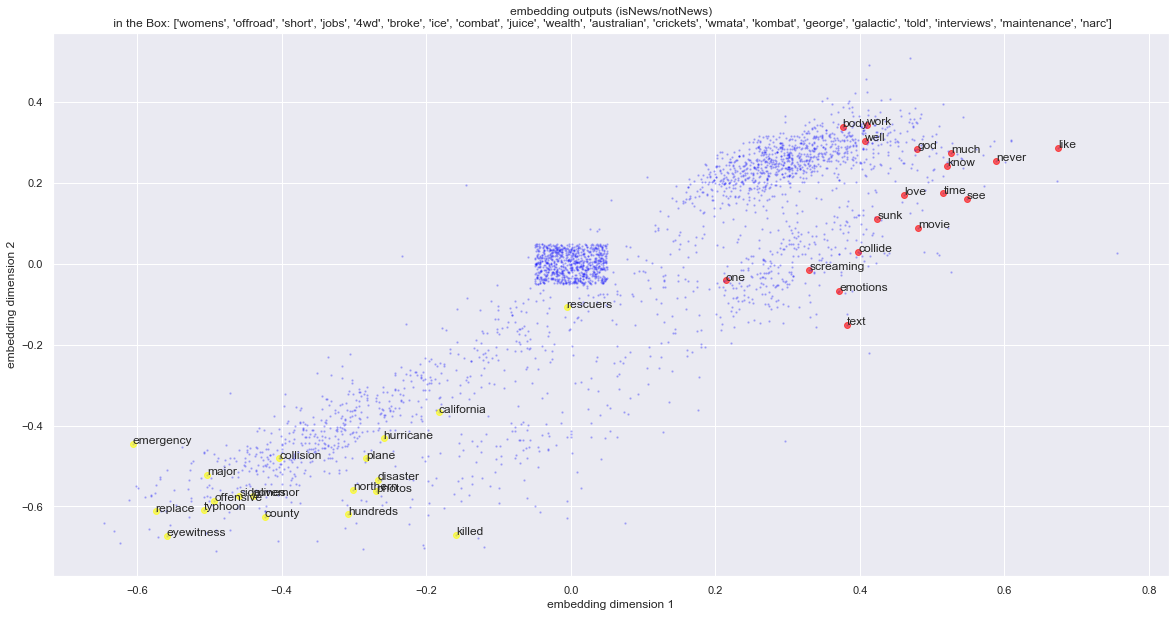

In [40]:
plt.figure(figsize = (20, 10))
box = []
count = 0
for i, (k, v) in enumerate(tokenizer.word_index.items()):
    plt.scatter(f[i, -1, 0], f[i, -1, 1], s = 2, color = 'blue', alpha = 0.2)
    if k in pos:
        plt.text(f[i, -1, 0], f[i, -1, 1], k, fontsize=12)
        plt.scatter(f[i, -1, 0], f[i, -1, 1], color = 'yellow', alpha = 0.6)
    if k in neg:
        plt.text(f[i, -1, 0], f[i, -1, 1], k, fontsize=12)
        plt.scatter(f[i, -1, 0], f[i, -1, 1], color = 'red', alpha = 0.6)
    if count < 20:
        if (0 < abs(f[i, -1, 0]) < 0.01) and (0 < abs(f[i, -1, 1]) < 0.01):
            count += 1
            box.append(k)
    if i > 2900:
        break
plt.title('embedding outputs (isNews/notNews)\n in the Box: {}'.format(box), fontsize = 12)
plt.xlabel('embedding dimension 1')
plt.ylabel('embedding dimension 2')